In [1]:
from google.colab import drive

drive.mount('/content/drive')
#root_path = 'drive/My Drive/Lab/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
print("Current working directory: "+os.getcwd())
default_path = '/content/drive/My Drive/Lab/API'
os.chdir(default_path)
print("Current working directory: "+os.getcwd())

Current working directory: /content
Current working directory: /content/drive/My Drive/Lab/API


In [3]:
IMAGE_PATH = "/content/drive/My Drive/Lab/quiz/"
MODEL_PATH = "/content/drive/My Drive/Lab/quiz/"

# For Graph
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []


## Import Support files and packages

In [4]:
from utils import *
#from image_transform import ImageTransform
from loader import Loader
from resnet import *
from graph_plot import *
from albumentation_transform import AlbumentationTransformations
from train import TrainModel
from test import TestModel
#from misclassified_images import MissclassifiedImages as ms
from display_images import *
#from correct_classified_images import CorrectclassifiedImages as cs
from albumentations import *
from albumentations.pytorch.transforms import ToTensor

## Setup device

In [5]:
# Device
SEED = 1
cuda = torch.cuda.is_available()
print("Cuda is available ?", cuda)
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)
device = torch.device("cuda" if cuda else "cpu")

Cuda is available ? True


## Model

In [6]:
K_S = 128
class QuizDNN(nn.Module):
    def __init__(self, dropout=0.05):
        super(QuizDNN, self).__init__()
        self.dropout_val = dropout
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=K_S, kernel_size=(3, 3), padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(K_S)
        self.conv2 = nn.Conv2d(in_channels=K_S, out_channels=K_S, kernel_size=(3, 3), padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(K_S)
        self.conv3 = nn.Conv2d(in_channels=K_S, out_channels=K_S, kernel_size=(3, 3), padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(K_S)
        self.pool = nn.MaxPool2d(2, 2)


        self.gap_linear = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(in_channels=K_S, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = F.relu(self.bn2(self.conv2(x1)))
        x3 = F.relu(self.bn3(self.conv3(x2+x1)))
        x3 = self.pool(x3)

        x5 = F.relu(self.bn3(self.conv3(x3)))
        x6 = F.relu(self.bn3(self.conv3(x5+x3)))
        x7 = F.relu(self.bn3(self.conv3(x6+x5+x3)))
        x7 = self.pool(x7)

        x9 = F.relu(self.bn3(self.conv3(x7)))
        x10 = F.relu(self.bn3(self.conv3(x7+x9)))
        x11 = F.relu(self.bn3(self.conv3(x7+x9+x10)))

        x12 = self.gap_linear(x11)
        x12 = x12.view(-1, 10)
        
        return x12


## Data augmentation, Dataset, DataLoader

In [7]:
img_mean = (0.4914, 0.4822, 0.4465)
img_std = (0.2023, 0.1994, 0.2010)
# Transforms
means = np.array(img_mean)
stdevs = np.array(img_std)
patch_size = 28

# Define Train transforms and Test transforms
# Cutout(num_holes=1, max_h_size=16, max_w_size=16, p=0.75),
transform_train = [
     # 
      #HorizontalFlip(p = 0.5),
      #GaussianBlur(),
      
      # RandomBrightnessContrast(),
      # HueSaturationValue(),
       #Downscale(),
      # RandomSizedCrop((patch_size,patch_size), patch_size,patch_size),      
      # RandomBrightness(),
      # RandomContrast(),
      Cutout(num_holes=1, max_h_size=16, max_w_size=16, p=0.75),
     # RGBShift(),
      #RandomRotate90(),
      HorizontalFlip(p = 0.5),
      # MotionBlur(),   
      Normalize(mean=means, std=stdevs),
      ToTensor()
    ]

transform_test = [Normalize(mean=means, std=stdevs),
      ToTensor()
    ]

# Create Train transforms and Test transforms
t_transform_train =  AlbumentationTransformations(transform_train)
t_transform_test = AlbumentationTransformations(transform_test)

# Dataset and DataLoader arguments
BATCH_SIZE = 64
dataset_name = torchvision.datasets.CIFAR10
trainSet_dict = dict(root='./data', train=True, download=True, transform=t_transform_train)
trainLoad_dict = dict(batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
testSet_dict = dict(root='./data', train=False, download=True, transform=t_transform_test)
testLoad_dict = dict(batch_size=32, shuffle=False, num_workers=4)


# Create Train Loader and Test Loader
trainloader = Loader.getDataLoader(dataset_name, trainSet_dict, trainLoad_dict)
testloader = Loader.getDataLoader(dataset_name, testSet_dict, testLoad_dict)
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## LR Finder


########## Tweaked version from fastai ###########



Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.23E-01


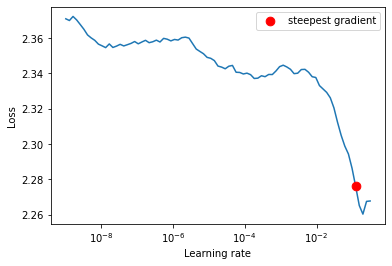

92
LR suggestion: steepest gradient
Suggested LR: 1.23E-01


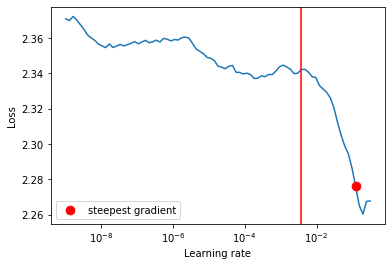

LR suggestion: steepest gradient
Suggested LR: 1.23E-01


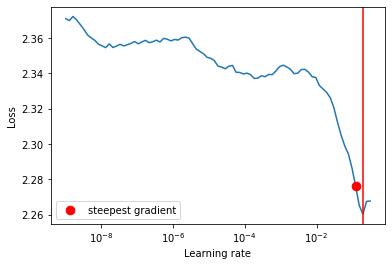

LR to be used: 0.024201282647943797


In [8]:
model = QuizDNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-10, weight_decay=1e-2)

from find_LR import *
bestLR = get_LR(model, trainloader, optimizer, criterion, device)

## Hyperparameters

In [9]:
# Hyper parameters
EPOCHS = 40
LAMBDA1=1e-5
LR=bestLR
MOMENTUM=0.9
WEIGHT_DECAY=.00001    #

## Loss Function, Optimizer and LR Scheduler

In [10]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# LR Scheduler
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

## Model Summary (Layers and Parameter)

In [11]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,456
       BatchNorm2d-2          [-1, 128, 32, 32]             256
            Conv2d-3          [-1, 128, 32, 32]         147,456
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 128, 32, 32]         147,456
       BatchNorm2d-6          [-1, 128, 32, 32]             256
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]         147,456
      BatchNorm2d-13          [-1, 128, 16, 16]             256
        MaxPool2d-14            [-1, 12

## Start training

In [12]:
filename = MODEL_PATH+"quiz_model.pth"

In [13]:
for epoch in range(EPOCHS):
  train_loss, train_acc, i = TrainModel.train(model, device, trainloader, criterion, optimizer, epoch)
  # scheduler.step()
  # scheduler.step(epoch + i / iters)
  train_losses.append(train_loss)
  train_accuracy.append(train_acc)
  test_loss, test_acc = TestModel.test(model, device, testloader, criterion)
  scheduler.step(test_loss)
  
  test_losses.append(test_loss)
  test_accuracy.append(test_acc)

  #save model

  state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict()}
  torch.save(state, filename)

: EPOCH= 0 Loss= 0.9881 Batch_id= 781 Accuracy= 44.94: 100%|██████████| 782/782 [00:34<00:00, 22.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.1091 Batch_id= 312 Accuracy= 2227/10000 (22.27%)



: EPOCH= 1 Loss= 1.3798 Batch_id= 781 Accuracy= 59.68: 100%|██████████| 782/782 [00:35<00:00, 22.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0765 Batch_id= 312 Accuracy= 3306/10000 (33.06%)



: EPOCH= 2 Loss= 1.9294 Batch_id= 781 Accuracy= 66.17: 100%|██████████| 782/782 [00:35<00:00, 22.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0664 Batch_id= 312 Accuracy= 3764/10000 (37.64%)



: EPOCH= 3 Loss= 0.7195 Batch_id= 781 Accuracy= 69.85: 100%|██████████| 782/782 [00:35<00:00, 22.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0615 Batch_id= 312 Accuracy= 4436/10000 (44.36%)



: EPOCH= 4 Loss= 0.5404 Batch_id= 781 Accuracy= 72.78: 100%|██████████| 782/782 [00:35<00:00, 22.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0790 Batch_id= 312 Accuracy= 3457/10000 (34.57%)



: EPOCH= 5 Loss= 1.4600 Batch_id= 781 Accuracy= 75.03: 100%|██████████| 782/782 [00:35<00:00, 22.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0523 Batch_id= 312 Accuracy= 4877/10000 (48.77%)



: EPOCH= 6 Loss= 0.8963 Batch_id= 781 Accuracy= 76.79: 100%|██████████| 782/782 [00:35<00:00, 22.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0525 Batch_id= 312 Accuracy= 4852/10000 (48.52%)



: EPOCH= 7 Loss= 1.0559 Batch_id= 781 Accuracy= 77.68: 100%|██████████| 782/782 [00:35<00:00, 22.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0498 Batch_id= 312 Accuracy= 5020/10000 (50.20%)



: EPOCH= 8 Loss= 0.5896 Batch_id= 781 Accuracy= 79.02: 100%|██████████| 782/782 [00:35<00:00, 22.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0481 Batch_id= 312 Accuracy= 5232/10000 (52.32%)



: EPOCH= 9 Loss= 0.8445 Batch_id= 781 Accuracy= 79.77: 100%|██████████| 782/782 [00:35<00:00, 22.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0340 Batch_id= 312 Accuracy= 6358/10000 (63.58%)



: EPOCH= 10 Loss= 0.9347 Batch_id= 781 Accuracy= 80.60: 100%|██████████| 782/782 [00:34<00:00, 22.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0347 Batch_id= 312 Accuracy= 6243/10000 (62.43%)



: EPOCH= 11 Loss= 0.7584 Batch_id= 781 Accuracy= 81.30: 100%|██████████| 782/782 [00:35<00:00, 22.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0411 Batch_id= 312 Accuracy= 5288/10000 (52.88%)



: EPOCH= 12 Loss= 0.5088 Batch_id= 781 Accuracy= 81.95: 100%|██████████| 782/782 [00:35<00:00, 22.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0392 Batch_id= 312 Accuracy= 5686/10000 (56.86%)



: EPOCH= 13 Loss= 0.2993 Batch_id= 781 Accuracy= 82.41: 100%|██████████| 782/782 [00:35<00:00, 22.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0309 Batch_id= 312 Accuracy= 6633/10000 (66.33%)



: EPOCH= 14 Loss= 0.1936 Batch_id= 781 Accuracy= 83.16: 100%|██████████| 782/782 [00:35<00:00, 22.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0486 Batch_id= 312 Accuracy= 4728/10000 (47.28%)



: EPOCH= 15 Loss= 0.7484 Batch_id= 781 Accuracy= 83.42: 100%|██████████| 782/782 [00:34<00:00, 22.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0393 Batch_id= 312 Accuracy= 5620/10000 (56.20%)



: EPOCH= 16 Loss= 0.5200 Batch_id= 781 Accuracy= 83.98: 100%|██████████| 782/782 [00:35<00:00, 22.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0337 Batch_id= 312 Accuracy= 6242/10000 (62.42%)



: EPOCH= 17 Loss= 0.3304 Batch_id= 781 Accuracy= 84.33: 100%|██████████| 782/782 [00:35<00:00, 22.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0581 Batch_id= 312 Accuracy= 4268/10000 (42.68%)



: EPOCH= 18 Loss= 0.8363 Batch_id= 781 Accuracy= 84.71: 100%|██████████| 782/782 [00:35<00:00, 22.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0538 Batch_id= 312 Accuracy= 4533/10000 (45.33%)



: EPOCH= 19 Loss= 0.6728 Batch_id= 781 Accuracy= 84.93: 100%|██████████| 782/782 [00:34<00:00, 22.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0624 Batch_id= 312 Accuracy= 4197/10000 (41.97%)



: EPOCH= 20 Loss= 0.7997 Batch_id= 781 Accuracy= 85.25: 100%|██████████| 782/782 [00:35<00:00, 22.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0510 Batch_id= 312 Accuracy= 4633/10000 (46.33%)



: EPOCH= 21 Loss= 0.6868 Batch_id= 781 Accuracy= 85.62: 100%|██████████| 782/782 [00:35<00:00, 22.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0577 Batch_id= 312 Accuracy= 4227/10000 (42.27%)



: EPOCH= 22 Loss= 0.9105 Batch_id= 781 Accuracy= 85.64: 100%|██████████| 782/782 [00:35<00:00, 22.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0655 Batch_id= 312 Accuracy= 3647/10000 (36.47%)



: EPOCH= 23 Loss= 0.4231 Batch_id= 781 Accuracy= 86.23: 100%|██████████| 782/782 [00:35<00:00, 22.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0554 Batch_id= 312 Accuracy= 4338/10000 (43.38%)



: EPOCH= 24 Loss= 0.8417 Batch_id= 781 Accuracy= 86.37: 100%|██████████| 782/782 [00:35<00:00, 22.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0535 Batch_id= 312 Accuracy= 4586/10000 (45.86%)



: EPOCH= 25 Loss= 0.2062 Batch_id= 781 Accuracy= 88.67: 100%|██████████| 782/782 [00:35<00:00, 22.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0623 Batch_id= 312 Accuracy= 3972/10000 (39.72%)



: EPOCH= 26 Loss= 0.4020 Batch_id= 781 Accuracy= 89.39: 100%|██████████| 782/782 [00:34<00:00, 22.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0562 Batch_id= 312 Accuracy= 4585/10000 (45.85%)



: EPOCH= 27 Loss= 0.1203 Batch_id= 781 Accuracy= 89.75: 100%|██████████| 782/782 [00:35<00:00, 22.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0594 Batch_id= 312 Accuracy= 4177/10000 (41.77%)



: EPOCH= 28 Loss= 0.4708 Batch_id= 781 Accuracy= 90.06: 100%|██████████| 782/782 [00:35<00:00, 22.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0583 Batch_id= 312 Accuracy= 4230/10000 (42.30%)



: EPOCH= 29 Loss= 0.6805 Batch_id= 781 Accuracy= 90.01: 100%|██████████| 782/782 [00:35<00:00, 22.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0602 Batch_id= 312 Accuracy= 4065/10000 (40.65%)



: EPOCH= 30 Loss= 0.1192 Batch_id= 781 Accuracy= 90.30: 100%|██████████| 782/782 [00:35<00:00, 22.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0697 Batch_id= 312 Accuracy= 3556/10000 (35.56%)



: EPOCH= 31 Loss= 0.1286 Batch_id= 781 Accuracy= 90.28: 100%|██████████| 782/782 [00:35<00:00, 22.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0819 Batch_id= 312 Accuracy= 3076/10000 (30.76%)



: EPOCH= 32 Loss= 0.6756 Batch_id= 781 Accuracy= 90.11: 100%|██████████| 782/782 [00:35<00:00, 22.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0704 Batch_id= 312 Accuracy= 3531/10000 (35.31%)



: EPOCH= 33 Loss= 0.3673 Batch_id= 781 Accuracy= 90.27: 100%|██████████| 782/782 [00:35<00:00, 22.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0725 Batch_id= 312 Accuracy= 3418/10000 (34.18%)



: EPOCH= 34 Loss= 0.6572 Batch_id= 781 Accuracy= 90.46: 100%|██████████| 782/782 [00:35<00:00, 22.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0697 Batch_id= 312 Accuracy= 3463/10000 (34.63%)



: EPOCH= 35 Loss= 0.4146 Batch_id= 781 Accuracy= 90.49: 100%|██████████| 782/782 [00:35<00:00, 22.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0805 Batch_id= 312 Accuracy= 2981/10000 (29.81%)



: EPOCH= 36 Loss= 0.4751 Batch_id= 781 Accuracy= 90.71: 100%|██████████| 782/782 [00:35<00:00, 22.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0920 Batch_id= 312 Accuracy= 2558/10000 (25.58%)



: EPOCH= 37 Loss= 0.3743 Batch_id= 781 Accuracy= 90.81: 100%|██████████| 782/782 [00:35<00:00, 22.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0776 Batch_id= 312 Accuracy= 3090/10000 (30.90%)



: EPOCH= 38 Loss= 0.2903 Batch_id= 781 Accuracy= 90.89: 100%|██████████| 782/782 [00:35<00:00, 22.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average Loss= 0.0840 Batch_id= 312 Accuracy= 2793/10000 (27.93%)



: EPOCH= 39 Loss= 0.4578 Batch_id= 781 Accuracy= 90.87: 100%|██████████| 782/782 [00:34<00:00, 22.42it/s]



Test set: Average Loss= 0.0895 Batch_id= 312 Accuracy= 2590/10000 (25.90%)



In [14]:
PATH = "/content/drive/My Drive/Lab/quiz"

## Show and Save losses and accuracy Plot

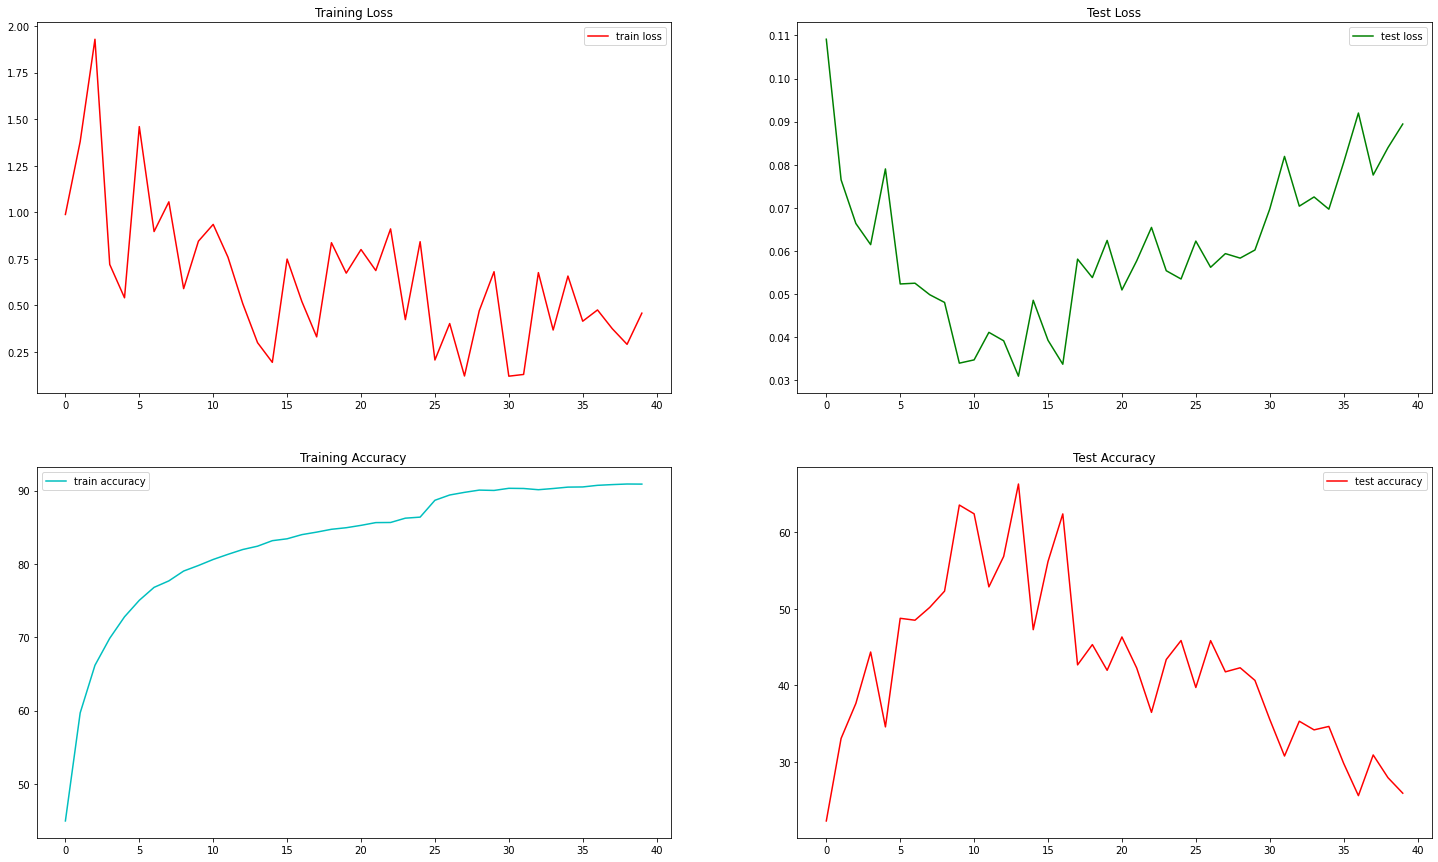

In [15]:
getPlottedGraph(EPOCHS, train_losses, train_accuracy, test_losses, test_accuracy,name="quiz_plot", PATH=PATH+str("/visualization/"))

## Load model

In [16]:
def load_checkpoint(model, optimizer,  filename='checkpoint.pth.tar'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        # losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

In [17]:
model = QuizDNN().to(device)
model, optimizer, start_epoch = load_checkpoint(model, optimizer,  filename)

=> loading checkpoint '/content/drive/My Drive/Lab/quiz/quiz_model.pth'
=> loaded checkpoint '/content/drive/My Drive/Lab/quiz/quiz_model.pth' (epoch 40)


## Show and Save correct classified images

/content/drive/My Drive/Lab/API/display_images.py:134: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  misclassified_imgs_indexes = (pred.eq(target.view_as(pred)) == False).nonzero()[:, 0]


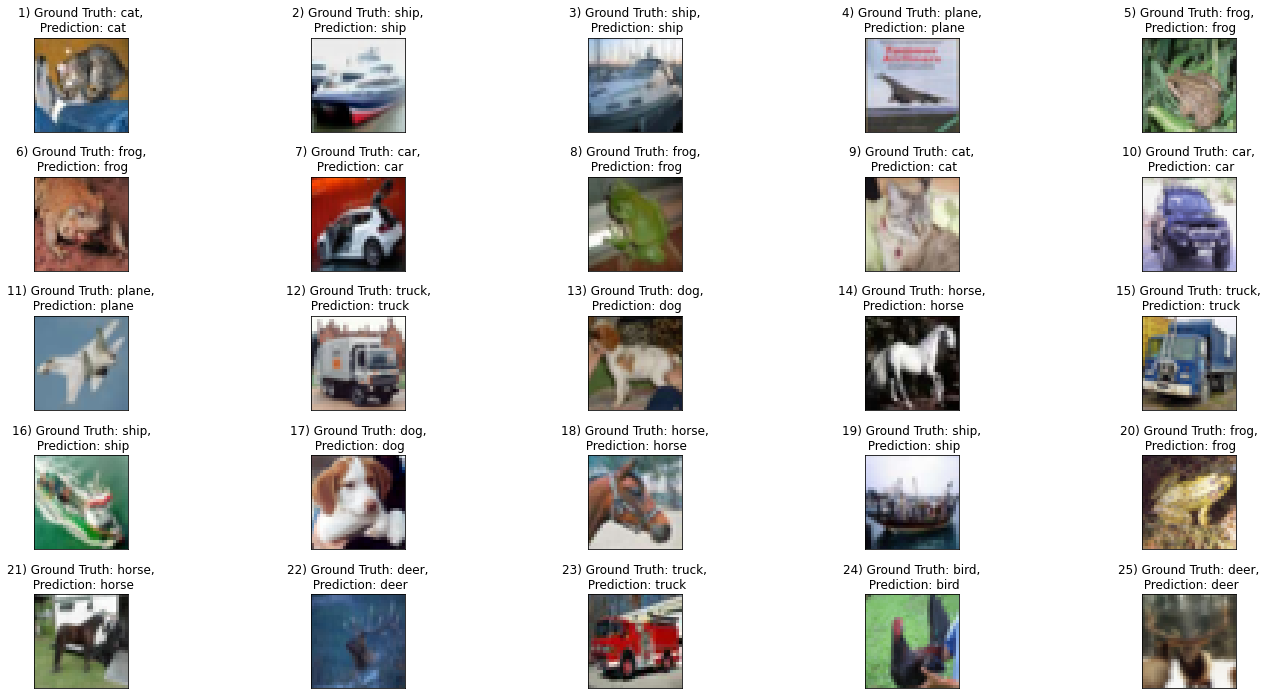

In [18]:
show_save_correctly_classified_images(model, testloader, device, PATH, name="correct_classified_imgs", max_correctly_classified_images_imgs=25,labels_list=classes)

## Show and Save misclassified images

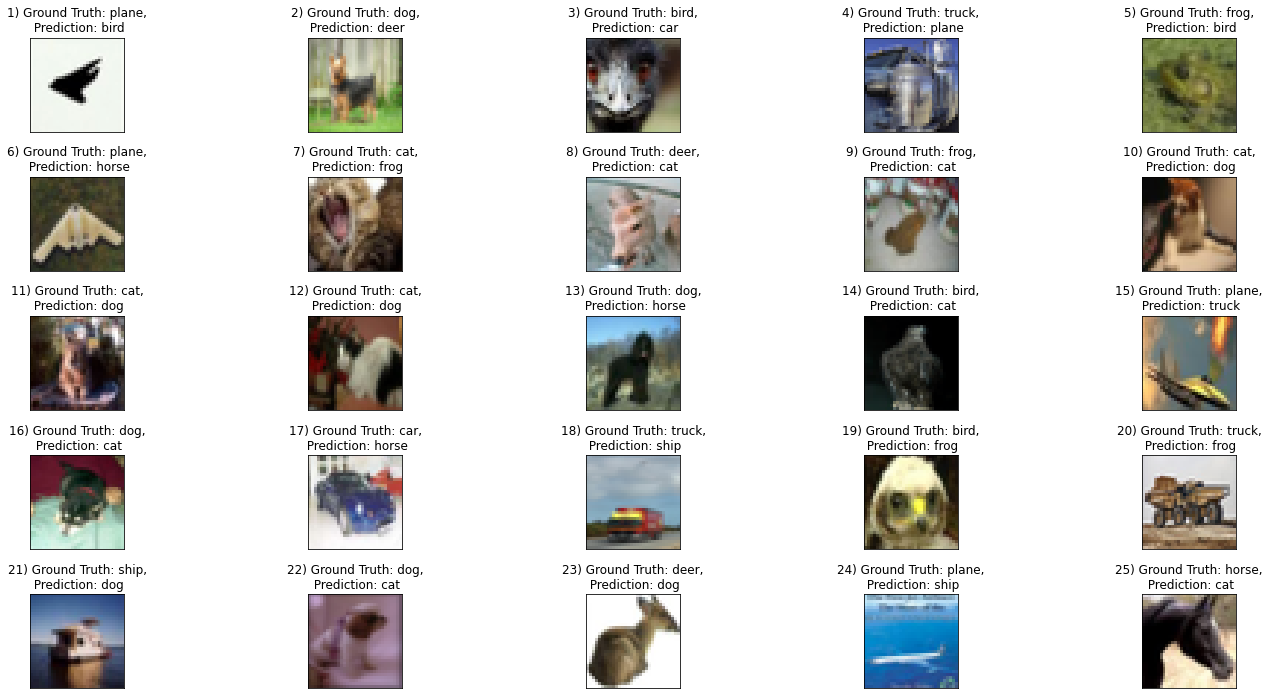

In [19]:
show_save_misclassified_images(model, testloader, device, PATH, name="misclassified_imgs", max_misclassified_imgs=25,labels_list=classes)